In [1]:
%matplotlib inline
from IPython.display import display
from matplotlib import pyplot as plt

import os
import sys
import torch
import random
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import seaborn as sns
from datetime import datetime

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

sys.path.append('../')
from MyPyUtil.logconf import logging
from MyPyUtil.util import show_more_rows, seed_everything

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# logging
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)

seed_everything()

pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False
pd.options.display.float_format = "{:.3f}".format

# max output width in numpy
np.set_printoptions(
    threshold=sys.maxsize,  # 20,
    edgeitems=10,
    linewidth=140,
    formatter=dict(float=lambda x: "%.3g" % x),
)  # float arrays %.3g

data_dir = f"{os.getcwd()}/../data/"
resources_dir = f"{os.getcwd()}/../resources/"

if os.path.exists(resources_dir) == False:
    os.makedirs(resources_dir, exist_ok=True)

if os.path.exists(data_dir) == False:
    os.makedirs(data_dir, exist_ok=True)

## Load Stock Data


In [3]:
import joblib
from build_stocks_data import tick_data_info

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)
empty_vol_threshold = 10

stks_data_file = (
    f"{resources_dir}nasdaq_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.pkl"
)

if os.path.exists(stks_data_file):
    stks_data = joblib.load(stks_data_file)
else:
    from build_stocks_data import build_stocks_data

    log.setLevel(logging.ERROR)
    stks_data = build_stocks_data(
        start, end, empty_vol_threshold, data_dir, resources_dir
    )
    joblib.dump(stks_data, stks_data_file)
    log.setLevel(logging.INFO)

display(f"The data has been loaded for a total of {len(stks_data)} stocks.")

'The data has been loaded for a total of 2260 stocks.'

In [10]:
df = stks_data[4].tick_data
display(df)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.846,19.894,19.715,19.755,17.297,234684800
2014-01-03,19.745,19.775,19.301,19.321,16.917,392467600
2014-01-06,19.195,19.529,19.057,19.426,17.009,412610800
2014-01-07,19.440,19.499,19.211,19.287,16.887,317209200
2014-01-08,19.243,19.484,19.239,19.409,16.994,258529600
...,...,...,...,...,...,...
2023-12-22,195.180,195.410,192.970,193.600,193.353,37122800
2023-12-26,193.610,193.890,192.830,193.050,192.804,28919300
2023-12-27,192.490,193.500,191.090,193.150,192.904,48087700


In [5]:
short_ind = 5
long_ind = 10


def to_adjusted(stk_data):
    """
    Adjusted Open = Open * Adjusted Close / Close
    Adjusted High = High * Adjusted Close / Close
    Adjusted Low = Low * Adjusted Close / Close
    Adjusted volume = Volume / (Adjusted Close / Close)
    """
    ratio_data = stk_data["Adj Close"] / stk_data["Close"]
    adjusted_OHLV = pd.DataFrame(index=stk_data.index)
    adjusted_OHLV["Adj Open"] = ratio_data * stk_data["Open"]
    adjusted_OHLV["Adj High"] = ratio_data * stk_data["High"]
    adjusted_OHLV["Adj Low"] = ratio_data * stk_data["Low"]
    adjusted_OHLV["Adj Close"] = stk_data["Adj Close"]
    adjusted_OHLV["Adj Volume"] = (ratio_data * stk_data["Volume"]).astype("int")
    # adjusted_OHLV["Pre Adj Close"] = stk_data["Adj Close"].shift(1)
    # adjusted_OHLV["Pre Adj Volume"] = adjusted_OHLV["Adj Volume"].shift(1)
    # adjusted_OHLV = adjusted_OHLV.dropna()
    # adjusted_OHLV["Pre Adj Volume"] = adjusted_OHLV["Pre Adj Volume"].astype("int")
    # adjusted_OHLV["B4_Adj Open pct"] = (
    #     adjusted_OHLV["Adj Open"] - adjusted_OHLV["Pre Adj Close"]
    # ) / adjusted_OHLV["Pre Adj Close"]
    # adjusted_OHLV["B4_Adj High pct"] = (
    #     adjusted_OHLV["Adj High"] - adjusted_OHLV["Pre Adj Close"]
    # ) / adjusted_OHLV["Pre Adj Close"]
    # adjusted_OHLV["B4_Adj Low pct"] = (
    #     adjusted_OHLV["Adj Low"] - adjusted_OHLV["Pre Adj Close"]
    # ) / adjusted_OHLV["Pre Adj Close"]
    # adjusted_OHLV["B4_Adj Volume pct"] = (
    #     adjusted_OHLV["Adj Volume"] - adjusted_OHLV["Pre Adj Volume"]
    # ) / adjusted_OHLV["Pre Adj Volume"]

    return adjusted_OHLV

&#128293; &#9778;
reference:

1. ![candlestick_patterns_8_trigrams](candlestick_patterns_8_trigrams.png)
2. [From Technical Indicators to Machine Learning: A Data-Driven Approach to Price Movement Forecasting](https://medium.com/@nemeth.marcell/from-technical-analysis-to-machine-learning-a-data-driven-approach-to-stock-price-forecasting-pt-1-66a4e3751b00)
3. [Stock Trend Prediction Using Candlestick Charting and Ensemble Machine Learning Techniques With a Novelty Feature Engineering Scheme](Stock_Trend_Prediction_Using_Candlestick_Charting_.pdf)


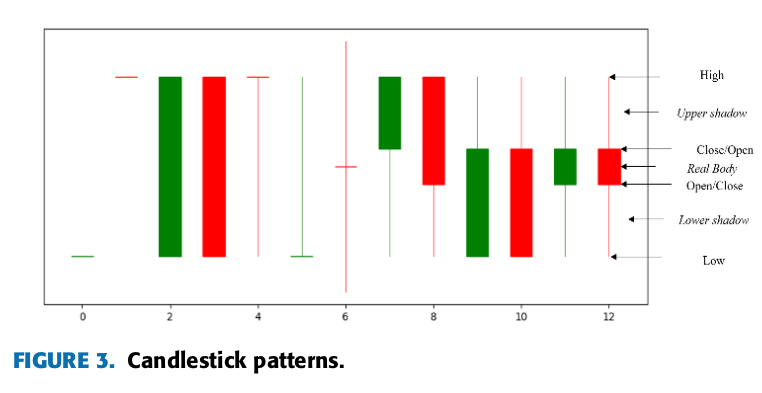
**classes:**  
0.

1.
2. CDLMARUBOZU - -100
3. CDLMARUBOZU - 100
4. CDLDOJI, 100, 收盤價 = 最高價
5. CDLDOJI, -100, 收盤價 = 最低價
6. CDLDOJI, 100, except 4 and 5
7. CDLHAMMER, -100 開盤價 = 最高價
8. CDLHAMMER, 100 收盤價 = 最高價
9. CDLINVERTEDHAMMER, -100 收盤價 = 最低價
10. CDLINVERTEDHAMMER, 100 開盤價 = 最低價
11. CDLSHORTLINE, CDLLONGLINE, -100
12. CDLSHORTLINE, CDLLONGLINE, 100


In [18]:
import pandas_ta

# Category
# with show_more_rows():
# display(pandas_ta.Category)
help(pandas_ta.sma)

Help on function sma in module pandas_ta.overlap.sma:

sma(close, length=None, talib=None, offset=None, **kwargs)
    Simple Moving Average (SMA)
    
    The Simple Moving Average is the classic moving average that is the equally
    weighted average over n periods.
    
    Sources:
        https://www.tradingtechnologies.com/help/x-study/technical-indicator-definitions/simple-moving-average-sma/
    
    Calculation:
        Default Inputs:
            length=10
        SMA = SUM(close, length) / length
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 10
        talib (bool): If TA Lib is installed and talib is True, Returns the TA Lib
            version. Default: True
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        adjust (bool): Default: True
        presma (bool, optional): If True, uses SMA for initial value.
        fillna (value, optional): pd.DataFrame.fillna(value)
     

In [25]:
close = "Close"
high = "High"
low = "Low"
volume = "Volume"
prefix = ""
suffix = ""

data = pd.DataFrame(index=df.index)
data["close"] = df[close]
data["sma20"] = df.ta.sma(close=close, length=20)
data["sma65"] = df.ta.sma(close=close, length=65)
data["ad"] = df.ta.ad(high=high, low=low, close=close, volume=volume)
data["obv"] = df.ta.obv(close=close, volume=volume)

data["ad20"] = data.ta.sma(close="ad", length=20)
data["ad65"] = data.ta.sma(close="ad", length=65)
data["obv20"] = data.ta.sma(close="obv", length=20)
data["obv65"] = data.ta.sma(close="obv", length=65)


data["OBV_ADL_BULL_DIVERGENCE"] = 0
data["OBV_ADL_BEAR_DIVERGENCE"] = 0

"""
[Daily Close < Daily SMA(65,Daily Close)] 
AND [Daily AccDist > Daily AccDist Signal (65)] 
AND [Daily OBV > Daily OBV Signal(65)] 
AND [Daily Close < Daily SMA(20,Daily Close)] 
AND [Daily AccDist > Daily AccDist Signal (20)] 
AND [Daily OBV > Daily OBV Signal(20)]
"""
data.loc[
    (data["close"] < data["sma65"])
    & (data["ad"] > data["ad65"])
    & (data["obv"] > data["obv65"])
    & (data["close"] < data["sma20"])
    & (data["ad"] > data["ad20"])
    & (data["obv"] > data["obv20"]),
    "OBV_ADL_BULL_DIVERGENCE",
] = 1

"""
[Daily Close > Daily SMA(65,Daily Close)] 
AND [Daily AccDist < Daily AccDist Signal (65)] 
AND [Daily OBV < Daily OBV Signal(65)] 
AND [Daily Close > Daily SMA(20,Daily Close)] 
AND [Daily AccDist < Daily AccDist Signal (20)] 
AND [Daily OBV < Daily OBV Signal(20)]
"""
data.loc[
    (data["close"] > data["sma65"])
    & (data["ad"] < data["ad65"])
    & (data["obv"] < data["obv65"])
    & (data["close"] > data["sma20"])
    & (data["ad"] < data["ad20"])
    & (data["obv"] < data["obv20"]),
    "OBV_ADL_BEAR_DIVERGENCE",
] = 1

data = data.dropna()

buy_sell_signals = pd.DataFrame(index=df.index)
buy_sell_signals[f"{prefix}OBV_ADL_BULL_DIVERGENCE{suffix}"] = data[
    "OBV_ADL_BULL_DIVERGENCE"
]
buy_sell_signals[f"{prefix}OBV_ADL_BEAR_DIVERGENCE{suffix}"] = data[
    "OBV_ADL_BEAR_DIVERGENCE"
]

with show_more_rows():
    display(data.head(100))
    display(buy_sell_signals.head(100))
    display(
        buy_sell_signals[
            (buy_sell_signals.OBV_ADL_BULL_DIVERGENCE > 0)
            | (buy_sell_signals.OBV_ADL_BEAR_DIVERGENCE)
        ]
    )

,close,sma20,sma65,ad,obv,ad20,ad65,obv20,obv65,OBV_ADL_BULL_DIVERGENCE,OBV_ADL_BEAR_DIVERGENCE
Date,,,,,,,,,,,
2014-04-04,18.994,19.107,19.035,-488941773.579,654214400.000,-428976805.293,-498349454.266,938943460.000,613094160.000,0,0
2014-04-07,18.695,19.093,19.019,-677138022.815,364364000.000,-438602543.592,-506756285.520,925662920.000,615089224.615,0,0
2014-04-08,18.694,19.071,19.009,-609427425.543,120475600.000,-446772367.311,-508583985.307,886226740.000,619370123.077,0,0
2014-04-09,18.940,19.060,19.002,-411533364.636,326645200.000,-452256793.731,-510954685.789,847132720.000,620475003.077,0,0
2014-04-10,18.696,19.047,18.992,-634802352.483,86993200.000,-459675073.550,-514453762.765,808943240.000,622773070.769,0,0
2014-04-11,18.558,19.038,18.979,-670616345.489,-184724400.000,-462104857.272,-520049639.499,769027840.000,616913489.231,0,0
2014-04-14,18.631,19.029,18.971,-504827381.805,20949600.000,-450578555.042,-519673427.045,729418900.000,618512720.000,0,0
2014-04-15,18.499,19.005,18.963,-428575765.021,-245540400.000,-443956903.928,-515204364.338,666003100.000,620704043.077,0,0
2014-04-16,18.536,18.983,18.954,-342359925.629,-30774800.000,-428802597.294,-508984423.708,624563380.000,620376486.154,0,0


,OBV_ADL_BULL_DIVERGENCE,OBV_ADL_BEAR_DIVERGENCE
Date,,
2014-01-02,NaN,NaN
2014-01-03,NaN,NaN
2014-01-06,NaN,NaN
2014-01-07,NaN,NaN
2014-01-08,NaN,NaN
2014-01-09,NaN,NaN
2014-01-10,NaN,NaN
2014-01-13,NaN,NaN
2014-01-14,NaN,NaN


,OBV_ADL_BULL_DIVERGENCE,OBV_ADL_BEAR_DIVERGENCE
Date,,
2014-10-20,0.000,1.000
2014-12-30,0.000,1.000
2015-01-08,0.000,1.000
2015-05-04,0.000,1.000
2015-05-08,0.000,1.000
2015-05-14,0.000,1.000
2015-05-15,0.000,1.000
2015-05-19,0.000,1.000
2015-05-20,0.000,1.000


In [32]:
if "candle_signal" in sys.modules:
    print("delete candle_signal module")
    del sys.modules["candle_signal"]
from candle_signal import create_candle_signals

if "eight_trigrams" in sys.modules:
    print("delete eight_trigrams module")
    del sys.modules["eight_trigrams"]
from eight_trigrams import create_trigrams

if "awesome_oscillator" in sys.modules:
    print("delete awesome_oscillator module")
    del sys.modules["awesome_oscillator"]
from strategies.awesome_oscillator import detect_awesome_saucers

if "strategies" in sys.modules:
    print("delete strategies")
    del sys.modules["strategies"]
from strategies import (
    macd_strategy,
    cti_strategy,
    er_strategy,
    eri_strategy,
    AD_OBV_strategy,
)

# if "cti_strategy" in sys.modules:
#     print("delete cti_strategy")
# from strategies.cti_strategy import cti_strategy

# if "er_strategy" in sys.modules:
#     print("delete er_strategy")
#     del sys.modules["er_strategy"]
# from strategies.er_strategy import er_strategy

# if "eri_strategy" in sys.modules:
#     print("delete eri_strategy")
#     del sys.modules["eri_strategy"]
# from strategies.eri_strategy import eri_strategy

# if "AD_OBV_strategy" in sys.modules:
#     print("delete AD_OBV_strategy")
#     del sys.modules["AD_OBV_strategy"]
# from strategies.AD_OBV_strategy import AD_OBV_strategy

import pandas_ta as ta


stk_data = stks_data[4].tick_data
short_ind = 5
long_ind = 10

adjusted_OHLV = to_adjusted(stk_data)

data = pd.concat(
    [
        AD_OBV_strategy.create_signals(
            adjusted_OHLV,
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            volume="Adj Volume",
            prefix="c",
            suffix="m",
        ),
        eri_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            length=13,
            prefix="c",
            suffix="m",
        ),
        er_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            close="Adj Close",
            prefix="c",
            suffix="m",
        ),
        adjusted_OHLV.ta.er(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        cti_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            close="Adj Close",
            fast=5,
            slow=10,
            prefix="c",
            suffix="m",
        ),
        adjusted_OHLV.ta.cti(
            close="Adj Close",
            length=5,
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.cti(
            close="Adj Close",
            length=10,
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.cfo(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.stochrsi(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.cmo(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.rsi(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.stoch(
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.rvi(
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="f",
            suffix="v",
        ),
        adjusted_OHLV.ta.mfi(
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            volume="Adj Volume",
            prefix="f",
            suffix="m",
        ),
        macd_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            close="Adj Close",
            fast=12,
            slow=26,
            signal=9,
            prefix="c",
            suffix="m",
        ),
        adjusted_OHLV.ta.brar(
            open="Adj Open",
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            scalar=1,
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.bop(
            open="Adj Open",
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.bias(close="Adj Close", prefix="f", suffix="m"),
        detect_awesome_saucers(
            adjusted_OHLV, high="Adj High", low="Adj Low", prefix="c", suffix="m"
        ),
        create_trigrams(
            adjusted_OHLV,
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="c",
            suffix="t",
        ),
        create_candle_signals(
            adjusted_OHLV,
            open="Adj Open",
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="c",
            suffix="c",
        ),
    ],
    axis=1,
)

with show_more_rows():
    display(data.head(100))

data = data.dropna()
display(data)

"""
# OVERLAP INDICATORS
data = pd.DataFrame()
# data["ma"] = tb.MA(df["Close"], timeperiod=short_ind)
# data["ema"] = tb.EMA(df["Close"], timeperiod=long_ind)
# data["dema"] = tb.DEMA(df["Close"], timeperiod=short_ind)
# data["kama"] = tb.KAMA(df["Close"], timeperiod=short_ind)
# data["sma"] = tb.SMA(df["Close"], timeperiod=long_ind)
# data["sar"] = tb.SAR(df["High"], df["Low"])

# MOMENTUM INDICATORS
data["adx"] = tb.ADX(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
data["cci"] = tb.CCI(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
data["apo"] = tb.APO(df["Close"], fastperiod=long_ind, slowperiod=short_ind)
data["bop"] = tb.BOP(df["Open"], df["High"], df["Low"], df["Close"])
data["macd"], data["macdsignal"], data["macdhist"] = tb.MACD(
    df["Close"], fastperiod=12, slowperiod=26, signalperiod=9
)
data["mfi"] = tb.MFI(
    df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=long_ind
)
data["mom"] = tb.MOM(df["Close"], timeperiod=long_ind)
data["rsi"] = tb.RSI(df["Close"], timeperiod=long_ind)

# # VOLUME INDICATORS
# data["ad"] = tb.AD(df["High"], df["Low"], df["Close"], df["Volume"])
# data["adosc"] = tb.ADOSC(
#     df["High"],
#     df["Low"],
#     df["Close"],
#     df["Volume"],
#     fastperiod=short_ind,
#     slowperiod=long_ind,
# )
# data["obv"] = tb.OBV(df["Close"], df["Volume"])
data["trange"] = tb.TRANGE(df["High"], df["Low"], df["Close"])
data["atr"] = tb.ATR(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
data["natr"] = tb.NATR(df["High"], df["Low"], df["Close"], timeperiod=long_ind)

# data.reset_index(drop=True, inplace=True)
display(data)
display(create_trigrams(df))
# TARGET
# data["target"] = df["Close"].pct_change().rolling(avg_days).mean().shift(avg_days)

# data.dropna(inplace=True)

# columns = ["Open", "High", "Volume", "Low", "trigrams", "target"]

# if custom == True:
#     df = create_signals(data=df)
#     columns = columns + [
#         "shortLineCdl",
#         "longLineCdl",
#         "spinningTop",
#         "closingMarubozu",
#     ]

# if "O" in additional:
#     columns = columns + ["ma", "ema", "dema", "kama", "sma", "sar"]
# if "M" in additional:
#     columns = columns + ["adx", "cci", "apo", "bop", "macd", "mfi", "mom", "rsi"]
# if "V" in additional:
#     columns = columns + ["ad", "adosc", "obv", "trange", "atr", "natr"]

# df = df[columns]
"""

delete candle_signal module
delete eight_trigrams module
delete strategies


AttributeError: module 'strategies.AD_OBV_strategy' has no attribute 'create_signals'